### 引入软件包，读取数据

In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linalg as la  #引入SVD分解包
from PIL import Image
from sklearn.cluster import KMeans #引入Kmeans聚类包
from scipy.spatial.distance import cdist 

In [6]:
#数据来源：https://archive.ics.uci.edu/ml/datasets/Online+Retail
raw_data = pd.read_excel('./Data/Online Retail.xlsx')
# raw_data = pd.read_excel('/data/Online Retail.xlsx')
raw_data = raw_data.fillna(0) #将NA值填充为0 

In [7]:
import sys
import sklearn
import matplotlib
print ('python version:',sys.version)
print ('numpy version:',np.__version__)
print ('pandas version:',pd.__version__)
print ('matplotlib version:',matplotlib.__version__)
print ('sklearn version:',sklearn.__version__)


python version: 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
numpy version: 1.16.5
pandas version: 0.23.0
matplotlib version: 3.1.3
sklearn version: 0.21.3


### 数据清洗

In [8]:
raw_data = raw_data[raw_data['Quantity']>=0] #InvoiceNo以c开头，quantity为负表示取消，剔除
raw_data = raw_data[~raw_data['StockCode'].isnull()] #去除没有商品ID
#计算天归属于哪一周
raw_data['year_week']=(raw_data['InvoiceDate'].dt.year)*100+raw_data['InvoiceDate'].dt.week
#去掉首末不完整两周
raw_data = raw_data[~((raw_data['year_week']==201048)|(raw_data['year_week']==201149))]
#将销量按周聚合
data = raw_data.groupby(['year_week','StockCode']).agg({'Quantity':'sum'}).reset_index()
data = data.pivot_table(index=['StockCode'],columns=['year_week'],values=['Quantity'])
data.columns = data.columns.droplevel(0)
data = data.reset_index().fillna(0)

### SVD分解

In [9]:
data = data.sample(frac=1)
x = data.iloc[:,1:].values
u,s,v = np.linalg.svd(x, full_matrices=False)

### 根据s矩阵选择合适的特征数量

feature_nums: 5


array([0.71670915, 0.83841934, 0.86536301, 0.882637  , 0.89297614,
       0.90169444, 0.90849441, 0.91517424, 0.92071655, 0.92603776,
       0.93082826, 0.93548188, 0.9394163 , 0.94317514, 0.94666363,
       0.94996056, 0.9531589 , 0.95618303, 0.95900702, 0.96164425,
       0.96411316, 0.96638474, 0.96863695, 0.97068868, 0.97254145,
       0.97437568, 0.97615351, 0.97785699, 0.97952029, 0.98102523,
       0.98241655, 0.9837633 , 0.98506768, 0.98634713, 0.98755671,
       0.98866485, 0.98972927, 0.99076692, 0.99178417, 0.99273351,
       0.99362329, 0.99448261, 0.99525677, 0.99602484, 0.99674775,
       0.9974416 , 0.99807993, 0.99865366, 0.9991442 , 0.99960945,
       1.        ])

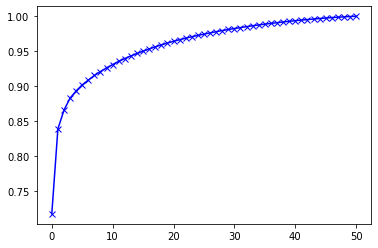

In [10]:
cum_var = []
for i in range(len(s)):
    if i == 0:
        cum_var.append(s[i] ** 2)
    else:
        cum_var.append(cum_var[-1] + s[i] ** 2)
cum_var_percentage = (cum_var / cum_var[-1])
plt.plot(range(len(cum_var_percentage)), cum_var_percentage, 'bx-')
min_explanatory_ratio = 0.90 #通过设定信息比来选取特征数量，也可以直接设定选取的特征数量
feature_nums = 0
for i in cum_var_percentage:
    if i < min_explanatory_ratio:
        feature_nums += 1
print ('feature_nums:',feature_nums)
cum_var_percentage

### 计算v矩阵与原始数据的相关系数

In [11]:
corr = [[] for i in range(feature_nums)]
t = data['StockCode']
for i in range(len(x)):
    for j in range(feature_nums):
        corr[j].append(np.corrcoef(x[i], v[j, :])[0][1])
for i in range(feature_nums):
    t = pd.concat([t, pd.Series(corr[i], index=data.index)], axis=1)
t.columns = ['StockCode'] + ['v{}'.format(i) for i in range(feature_nums)]

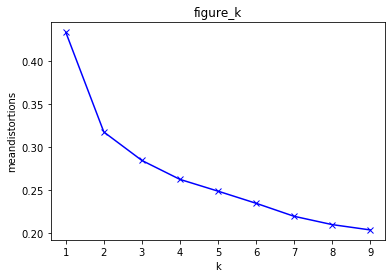

In [12]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib as mpl
#选取k值
x_cluster = t.iloc[:, 1:].values #根据原始数据与V向量的相关系数来做k-means
K=range(1,10)
meandistortions=[]
for k in K:
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(x_cluster)
    meandistortions.append(sum(np.min(cdist(x_cluster,kmeans.cluster_centers_,"euclidean"),axis=1))/x_cluster.shape[0])
plt.plot(K,meandistortions,'bx-')
plt.xlabel('k')
plt.ylabel("meandistortions")
plt.title("figure_k")
plt.show()

### 对求得的系数矩阵进行k-means聚类

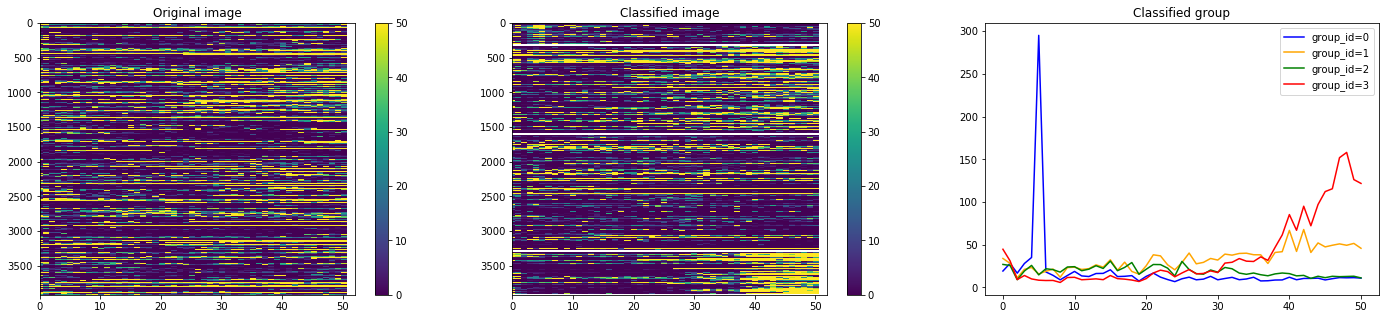

In [13]:
class_number = 4 #设定kmeans聚类数
x_cluster[np.isnan(x_cluster)] = 0 #填充NA值
kmeans = KMeans(n_clusters=class_number,random_state=100).fit(x_cluster) #KMeans聚类
kmeans_label =kmeans.labels_

data_res = pd.concat([data[['StockCode']], pd.Series(kmeans_label,index=data.index)], axis=1) #把Kmeans分类结果和driver_id对应
data_res.columns=['StockCode','group_id']

idx_sort = np.argsort(data_res.group_id) #按分类后的group_id排序原始数据，相同类别数据排在一起
group_nums = data_res[['StockCode','group_id']].groupby(['group_id']).count().cumsum()

vmax=50
plt.figure(figsize=(24, 5))
plt.subplot(131)
cmap = mpl.cm.viridis
im = plt.imshow(x[: , :], aspect='auto',cmap=cmap,vmax=vmax)
plt.xlim(0,data.shape[1])
plt.colorbar(im,cmap=cmap)
plt.title('Original image')

plt.subplot(132)
cmap = mpl.cm.viridis
im = plt.imshow(x[idx_sort, :],aspect='auto',cmap=cmap,vmax=vmax)
for i in range(class_number):
    plt.hlines(y=int(group_nums['StockCode'][i]) - 1, xmin=-1, xmax=data.shape[1], color='white', linewidth=2)
plt.xlim(0,data.shape[1])
plt.colorbar(im,cmap=cmap)
plt.title('Classified image')

color_list = ['blue','orange','green','red','purple','pink']
plt.subplot(133)
for i in range(class_number):
    plt.plot(x[kmeans_label==i, :].mean(axis=0), label='group_id='+str(i),color=color_list[i])
plt.legend()
plt.title('Classified group')
plt.show()